The basic question we are trying to answer with this notebook is:

*What's the difference between a CSLC image that is radiometrically terrain corrected post-production and a radiometric terrain corrected product?*

In theory, the difference should be that the RTC product performs the radiometric terrain correction in the native resolution, whereas the CSLC performs the geocoding step first, reducing that native resolution.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
from astropy.visualization import ImageNormalize, ZScaleInterval

In [2]:
# Open Static layer CSLC h5 file
f = h5py.File('cslc_unzipped/cslc/OPERA_L2_CSLC-S1-STATIC_T004-006637-IW3_20140403_S1A_v1.0.h5', "r")
# Data CSLC h5 file
f2 = h5py.File('cslc_unzipped/cslc/OPERA_L2_CSLC-S1_T094-200132-IW3_20231224T032111Z_20231225T081521Z_S1A_VV_v1.0.h5', "r")
vv = f2['data/VV'][()]
beta_naught_calibration_scalar = f2['metadata/calibration_information/beta_naught'][()]
# VV RTC file
vv_rtc = rasterio.open('cslc_unzipped/cslc/OPERA_L2_RTC-S1_T094-200132-IW3_20231224T032111Z_20231224T110416Z_S1A_30_v1.0_VV.tif', "r")
vv_rtc_data = vv_rtc.read(1)

The RTC product is provided in the $\gamma^0$ convention. To compare like-to-like, we will first convert the CSLC to $\beta^0$ and then $\gamma^0$.

From the [Sentinel-1 algorithm definition](https://sentinels.copernicus.eu/documents/247904/1877131/S1-TN-MDA-52-7445_Sentinel-1+Level+1+Detailed+Algorithm+Definition_v2-5.pdf/), 

$$
\begin{equation} 
    DN_i^{scaled} = S_i \times DN_i \tag{9-47}
\end{equation}
$$

where $S_i$ is the scaling Look-Up Table (LUT) value
and $DN_i$ and $DN_i^{scaled}$ are the unscaled and scaled digital numbers respectively. 

$$
\begin{equation} 
    lutBeta0(i) = S_i \sqrt{K_{abs}} \tag{9-52}
\end{equation}
$$

where $lutBeta0(i)$ is the range-dependent function to convert to $\beta^0$ and $K_{abs}$ is the absolute calibration constant.

$$
\begin{equation} 
    \beta^0_i = \frac{DN_i^2}{K_{abs}} \tag{9-48}
\end{equation} 
$$

Substituting eqn. (9-47) into eqn. (9-48) we get:

$$
\begin{equation}
    \beta^0_i = \frac{DN_i^{scaled^2}}{S_i^2 K_{abs}} 
\end{equation}
$$

which  can be rewritten as the following using eqn. (9-52)

$$
\begin{equation}
   \beta^0_i = \frac{DN_i^2}{lutBeta0(i)^2} \tag{9-56}
\end{equation}
$$

So $lutBeta0(i)$ accounts for a range-dependent scaling and an absolute calibration scaling, as reflected by eqn. (9-52).

In [3]:
# Convert complex DN to beta_nought
beta_nought = np.abs(vv)**2 / beta_naught_calibration_scalar**2

In [4]:
# Construct CSLC transform from x and y coords
x_coords = f2['data/x_coordinates/'][()]
y_coords = f2['data/y_coordinates/'][()]

x_spacing = np.diff(x_coords)
# Check whether constant resolution can be assumed
assert (x_spacing == x_spacing[0]).sum() == len(x_spacing), "Unequal spacing - check x_spacing"

y_spacing = np.diff(y_coords)
assert (y_spacing == y_spacing[0]).sum() == len(y_spacing), "Unequal spacing - check y_spacing"

# Adjust back by half a pixel as coords use pixel centre
cslc_transform = Affine.translation(x_coords[0] - x_spacing[0] / 2, y_coords[0] - y_spacing[0] / 2) * Affine.scale(x_spacing[0], y_spacing[0])

In [5]:
# Write out cslc data to raster
new_dataset = rasterio.open(
    'new_linear.tif',
    'w',
    driver='GTiff',
    height=len(y_coords),
    width=len(x_coords),
    count=1,
    dtype=vv_rtc.dtypes[0],
    crs='EPSG:32606',
    transform=cslc_transform,
)

new_dataset.write(beta_nought, 1)
new_dataset.close()

**Resample** - the CSLC (5m east by 10m north) to the RTC resolution (30m by 30m)

In [6]:
# Open the input dataset
dataset = rasterio.open("new_linear.tif")

# Resample 
width_downscale_factor = vv_rtc.res[0]//dataset.res[0]
height_downscale_factor = vv_rtc.res[1]//dataset.res[1]

# Calculate the target shape
target_height = int(dataset.height / height_downscale_factor)
target_width = int(dataset.width / width_downscale_factor)

# Resample data to target shape
data = dataset.read(
    out_shape=(
        dataset.count,  # Number of bands
        target_height,
        target_width
    ),
    resampling=Resampling.bilinear
)

# Scale image transform
scaled_transform = dataset.transform * Affine.scale(
    (dataset.width / target_width),
    (dataset.height / target_height)
)

# Define the metadata for the output raster
profile = dataset.profile
profile.update({
    'height': target_height,
    'width': target_width,
    'transform': scaled_transform,
    'dtype': vv_rtc.dtypes[0],
    'crs': dataset.crs
})

# Close the input dataset
dataset.close()

# Open the output dataset
with rasterio.open('resampled_linear.tif', 'w', **profile) as resampled_dataset:
    resampled_dataset.write(data)

assert resampled_dataset.res == (30.0, 30.0)

To convert from $\beta^0$ to $\gamma^0$, we use the `rtc_anf_gamma0_to_beta0.tif` layer as the conversion factor $C$ using the following equation

$$
\begin{equation}
\beta^0 = C\gamma^0
\end{equation}
$$

$$
\begin{equation}
\implies \boxed{\gamma^0 = \beta^0/C}
\end{equation}
$$

$$
\begin{equation}
\implies C = \frac{A_\gamma}{A_\beta} = \frac{\cos \theta_i}{\cos \psi}
\end{equation}
$$

In [7]:
resampled = rasterio.open("resampled_linear.tif", "r")
resampled_data = resampled.read(1)

# Apply beta_nought to gamma_nought conversion
gb = rasterio.open("cslc_unzipped/cslc/OPERA_L2_RTC-S1-STATIC_T094-200132-IW3_20140403_S1A_30_v1.0_rtc_anf_gamma0_to_beta0.tif", "r")
gb_data = gb.read(1)

resampled_db = 10*np.log10(resampled_data/gb_data)
# resampled_db = 10*np.log10(resampled_data/np.sqrt(gb_data))
vv_rtc_db = 10*np.log10(vv_rtc_data)

In [8]:
rtc_min, rtc_max = np.nanmin(vv_rtc_db), np.nanmax(vv_rtc_db)

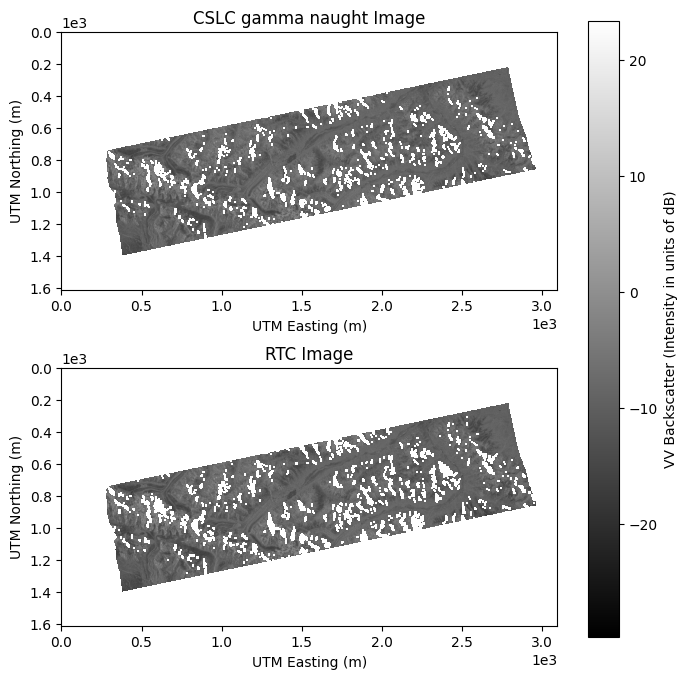

CLSC shape: (1612, 3098) | RTC shape: (1612, 3098)


In [9]:
# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Adjust vertical spacing between subplots
plt.subplots_adjust(hspace=0.2)  # Set the vertical space between subplots

# Plot data on the first subplot (top subplot)
img1 = ax1.imshow(resampled_db, vmin=rtc_min, vmax=rtc_max, cmap='gray')
ax1.set_title('CSLC gamma naught Image')
ax1.set_aspect('equal')

# Plot data on the second subplot (bottom subplot)
img2 = ax2.imshow(vv_rtc_db, vmin=rtc_min, vmax=rtc_max, cmap='gray')
ax2.set_title('RTC Image')
ax2.set_aspect('equal')

# Create a single colorbar for both subplots
cbar = fig.colorbar(img2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('VV Backscatter (Intensity in units of dB)')

# Set scientific notation for ticks on both subplots
for ax in [ax1, ax2]:
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))

# Enable math text for axes labels
ax1.set_xlabel(r'UTM Easting (m)')
ax1.set_ylabel(r'UTM Northing (m)')
ax2.set_xlabel(r'UTM Easting (m)')
ax2.set_ylabel(r'UTM Northing (m)')

# Show the plot
plt.show()

print(f"CLSC shape: {resampled_db.shape} | RTC shape: {vv_rtc_db.shape}")


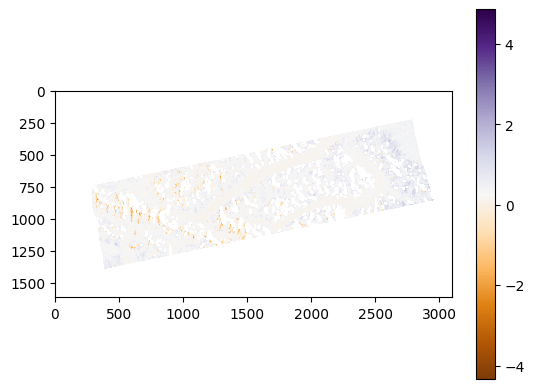

In [10]:
diff_db = resampled_db - vv_rtc_db

# Create an ImageNormalize object
norm = ImageNormalize(diff_db, interval=ZScaleInterval())

plt.imshow(diff_db, norm=norm, cmap = 'PuOr')
plt.colorbar()
plt.show()

In [11]:
# Create a DataFrame with the data and column names
df = pd.DataFrame({'CSLC_DB': resampled_db.flatten(), 'RTC_DB': vv_rtc_db.flatten(), 'DIFF_DB': diff_db.flatten()})

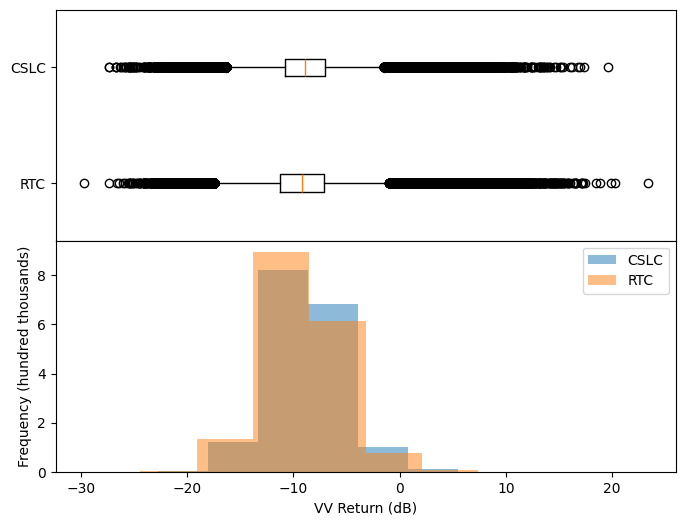

In [12]:
from matplotlib.ticker import FuncFormatter

# Function to format y-axis ticks
def millions_formatter(x, pos):
    return '{:.0f}'.format(x/1e5)

# Create a figure and subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plotting the first boxplot on ax1
ax1.boxplot([df['RTC_DB'].dropna(), df['CSLC_DB'].dropna()], labels=['RTC', 'CSLC'], vert=False)

# Remove x-axis ticks for ax1
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Plotting the histograms on ax2
ax2.hist(resampled_db.flatten(), alpha=0.5, label='CSLC')
ax2.hist(vv_rtc_db.flatten(), alpha=0.5, label='RTC')
ax2.set_ylabel("Frequency (hundred thousands)")
ax2.set_xlabel("VV Return (dB)")
ax2.legend()

# Format y-axis ticks to display in units of 100,000 (K)
ax2.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Adjust layout to remove gaps
plt.subplots_adjust(hspace=0)

# Display the plot
plt.show()

In [13]:
mae = np.mean(np.abs(df['DIFF_DB']))
mse = np.mean(df['DIFF_DB']**2)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.7214592099189758
Mean Squared Error: 1.1835285425186157


In [14]:
10**0.072

1.1803206356517297

Using the Mean Absolute Error as the typical difference between the CSLC image $c$ and RTC image $r$, the difference on a linear power scale is

$10\log_{10}(c) - 10\log_{10}(r) = 10\log_{10}(\frac{c}{r}) \sim 0.72$

$\therefore c/r \sim 10^{\frac{0.22}{10}} \sim 1.18$